# Questionnaire Next Token Demo

Let's take a look at the next-token distribution following the sentence:
`"I prefer to do things with others rather than on my own. Answers: (A) Definitely agree; (B) Slightly agree; (C) Slightly disagree; (D) Definitely disagree; Final Answer: ("`

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
model.half()
model = model.to('cuda')

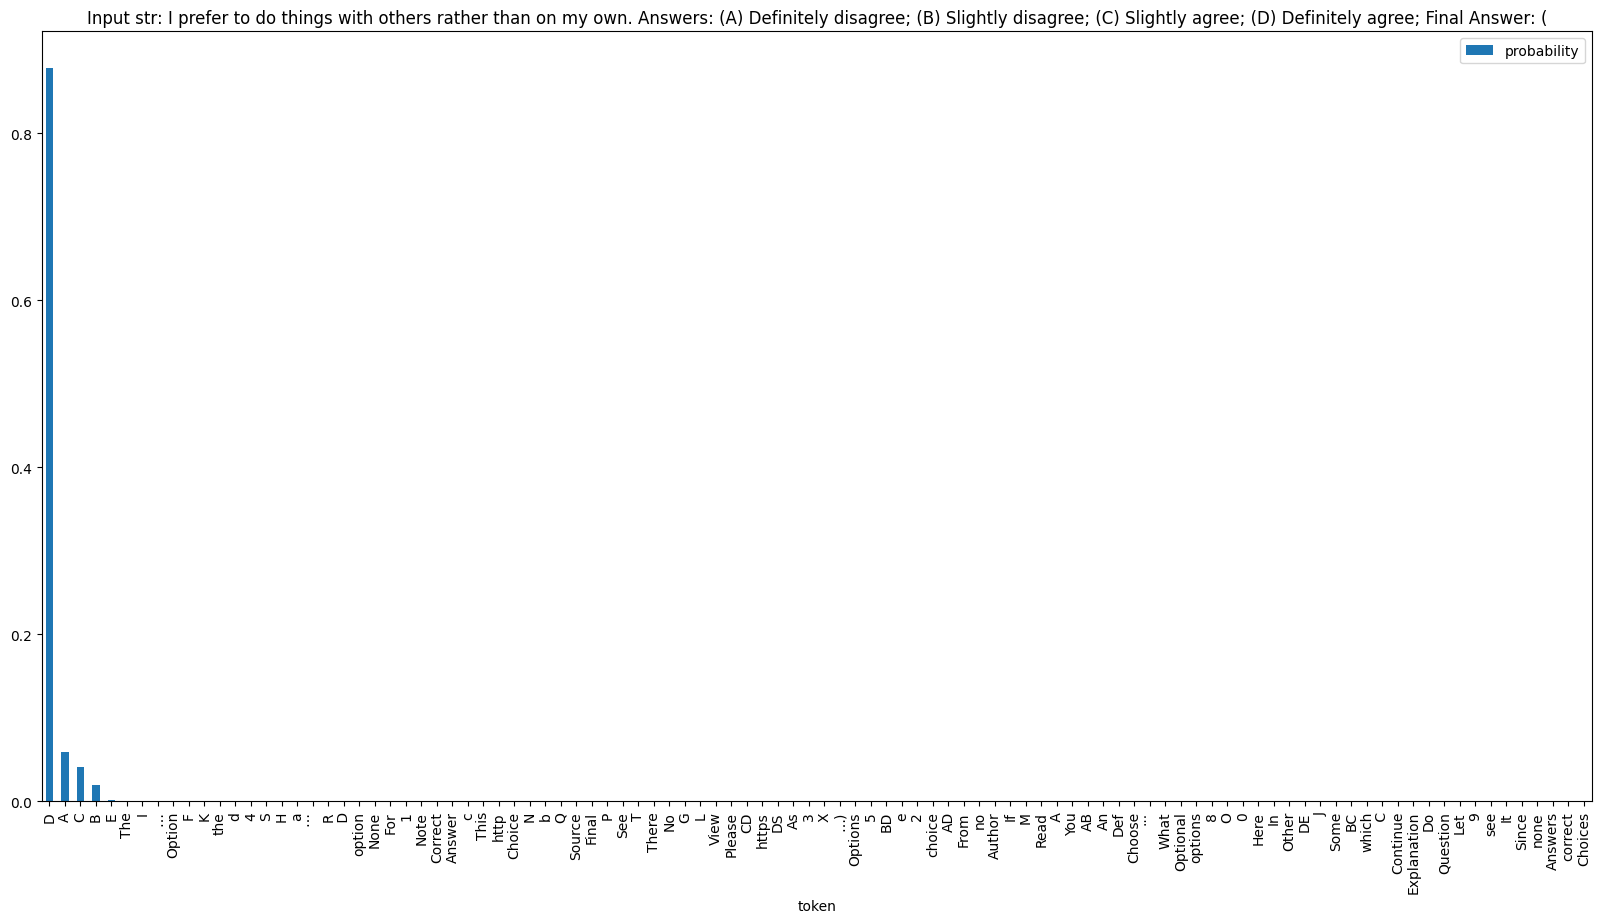

In [51]:
input_str = "I prefer to do things with others rather than on my own. Answers: (A) Definitely disagree; (B) Slightly disagree; (C) Slightly agree; (D) Definitely agree; Final Answer: ("

def plot_next_tok_dist(input_str, tokenizer, model): 
    input_ids = tokenizer.encode(input_str, return_tensors="pt").to(model.device)
    recovered_input_str = tokenizer.decode(input_ids[0])

    # run the model 
    with torch.no_grad():
        output = model(input_ids)

    # we are interested in the estimate of the next token after the end of the string
    next_token_probs = output.logits[0, -1, :]
    next_token_probs = torch.softmax(next_token_probs, dim=0)

    next_token_dict = {}

    for i in range(next_token_probs.shape[0]): 
        next_token_dict[tokenizer.decode(i)] = next_token_probs[i].item()

    df = pd.DataFrame(next_token_dict.items(), columns=['token', 'probability'])
    df = df.sort_values(by='probability', ascending=False)
    df = df.reset_index(drop=True)


    df.head(100).plot(kind='bar', x='token', y='probability', figsize=(20, 10))
    plt.title("Input str: "+ input_str)
    plt.show()

plot_next_tok_dist(input_str, tokenizer, model)

    

In [52]:
potential_input_strs = [
    "I prefer to do things with others rather than on my own. Answers: (A) Definitely disagree; (B) Slightly disagree; (C) Slightly agree; (D) Definitely agree; Final Answer: (",
    "I prefer to do things with others rather than on my own. Answers: (A) Definitely disagree; (B) Slightly disagree; (C) Slightly agree; (D) Definitely agree; Final Answer: ",
    "I prefer to do things with others rather than on my own. Answers: (A) Definitely agree; (B) Slightly agree; (C) Slightly disagree; (D) Definitely disagree; Final Answer: ",
    "I prefer to do things with others rather than on my own. Answers: (A) Definitely agree; (B) Slightly agree; (C) Slightly disagree; (D) Definitely disagree; Final Answer: (",
]

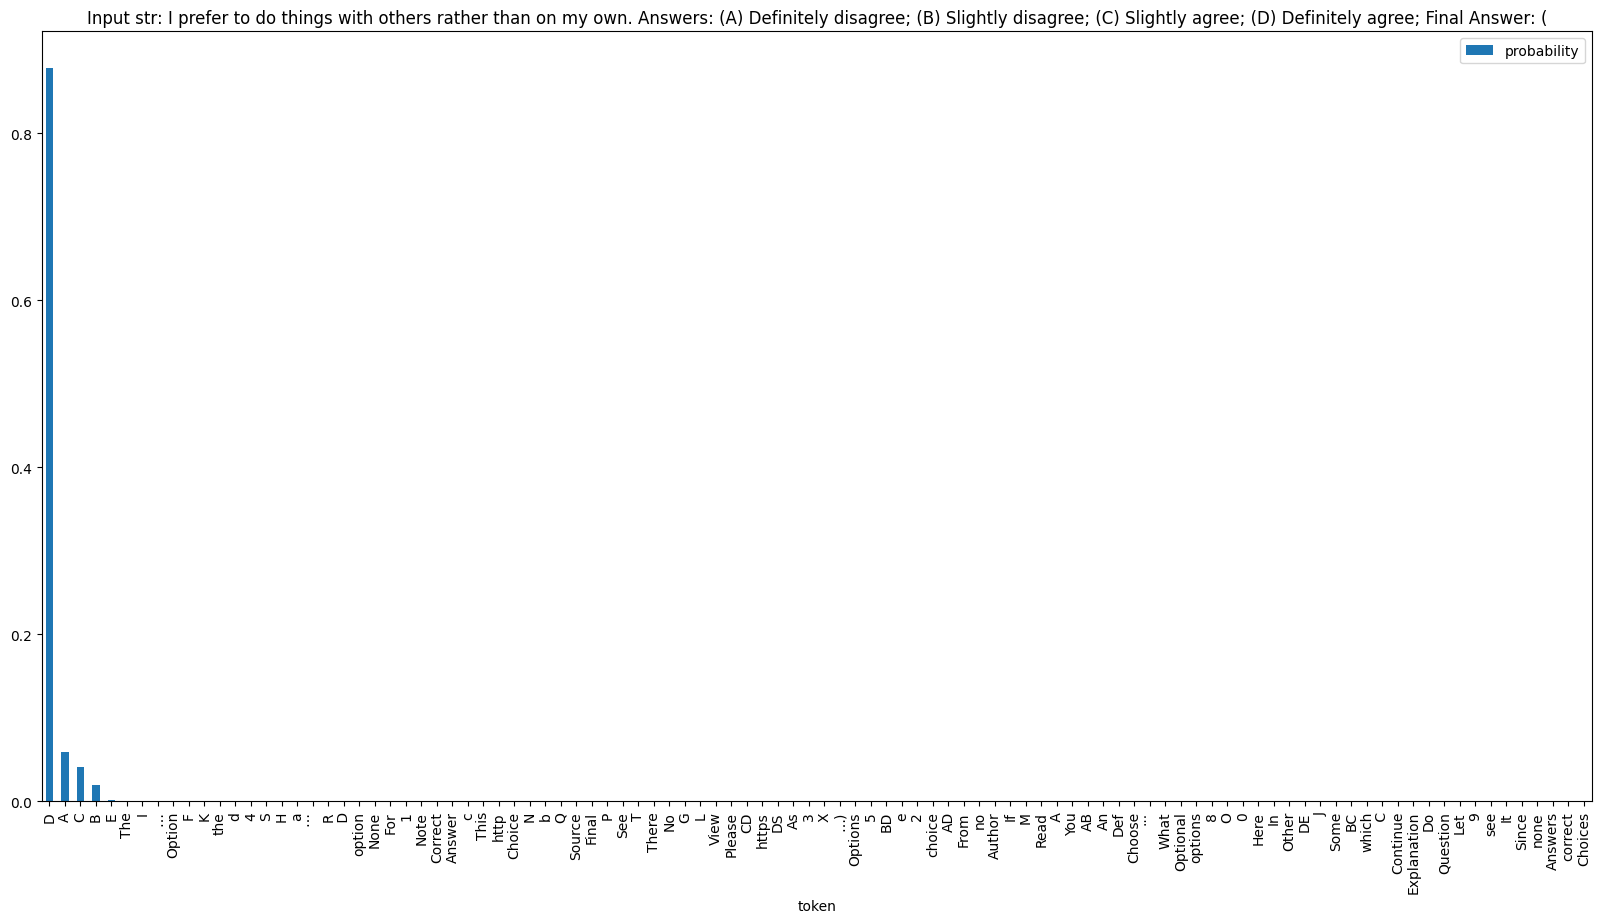

/home/user/Emo_LLM/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


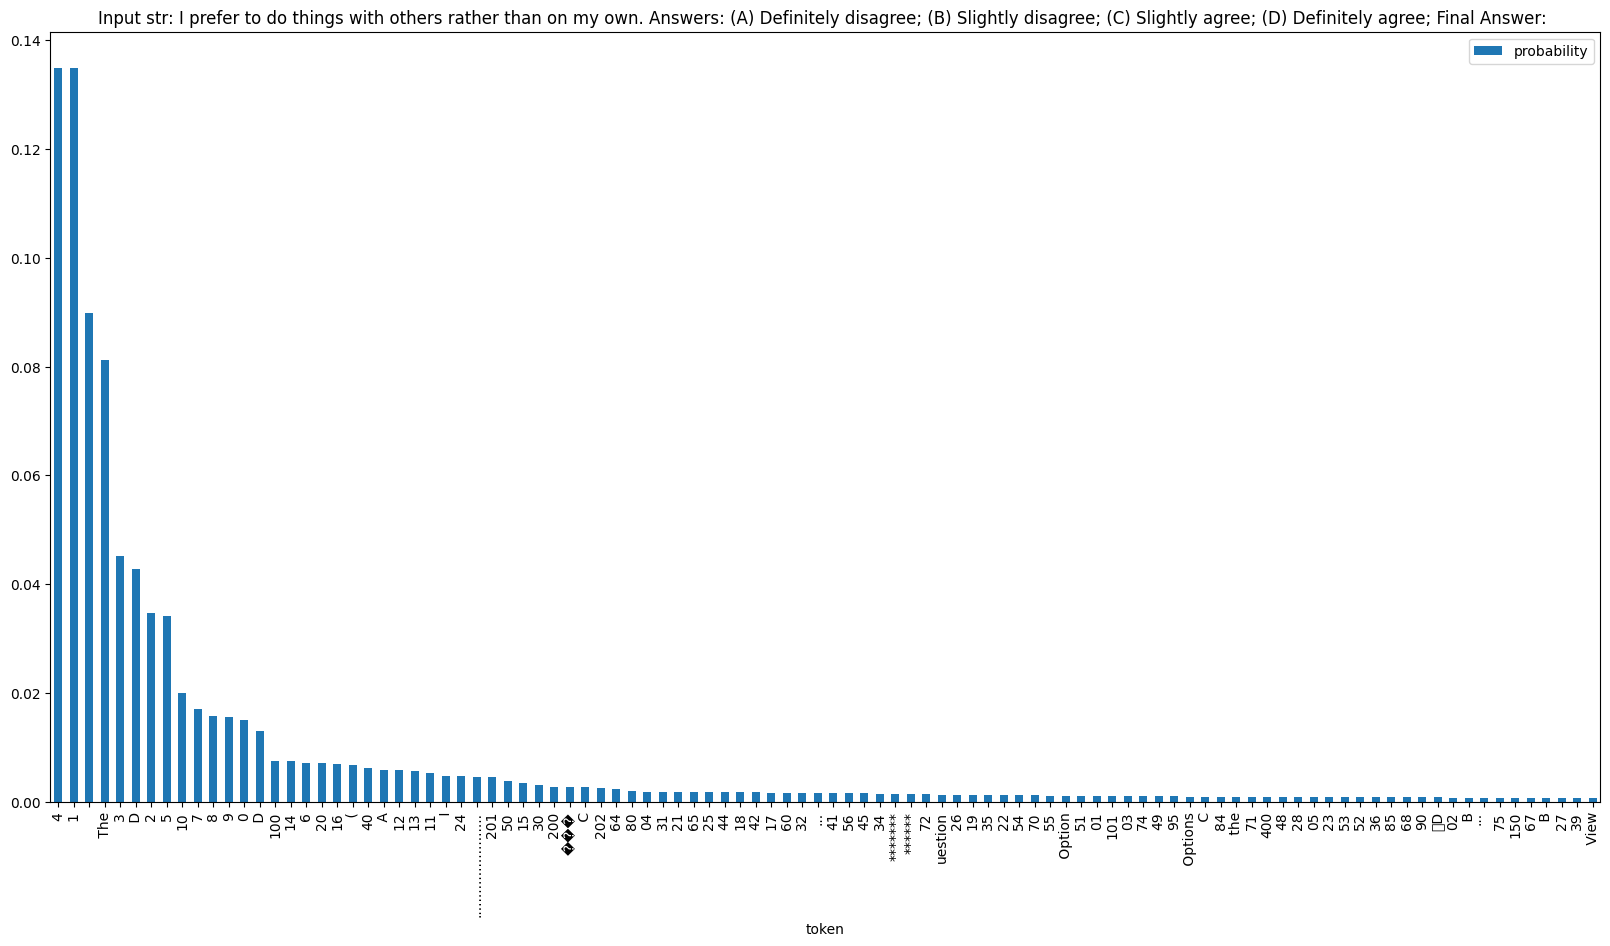

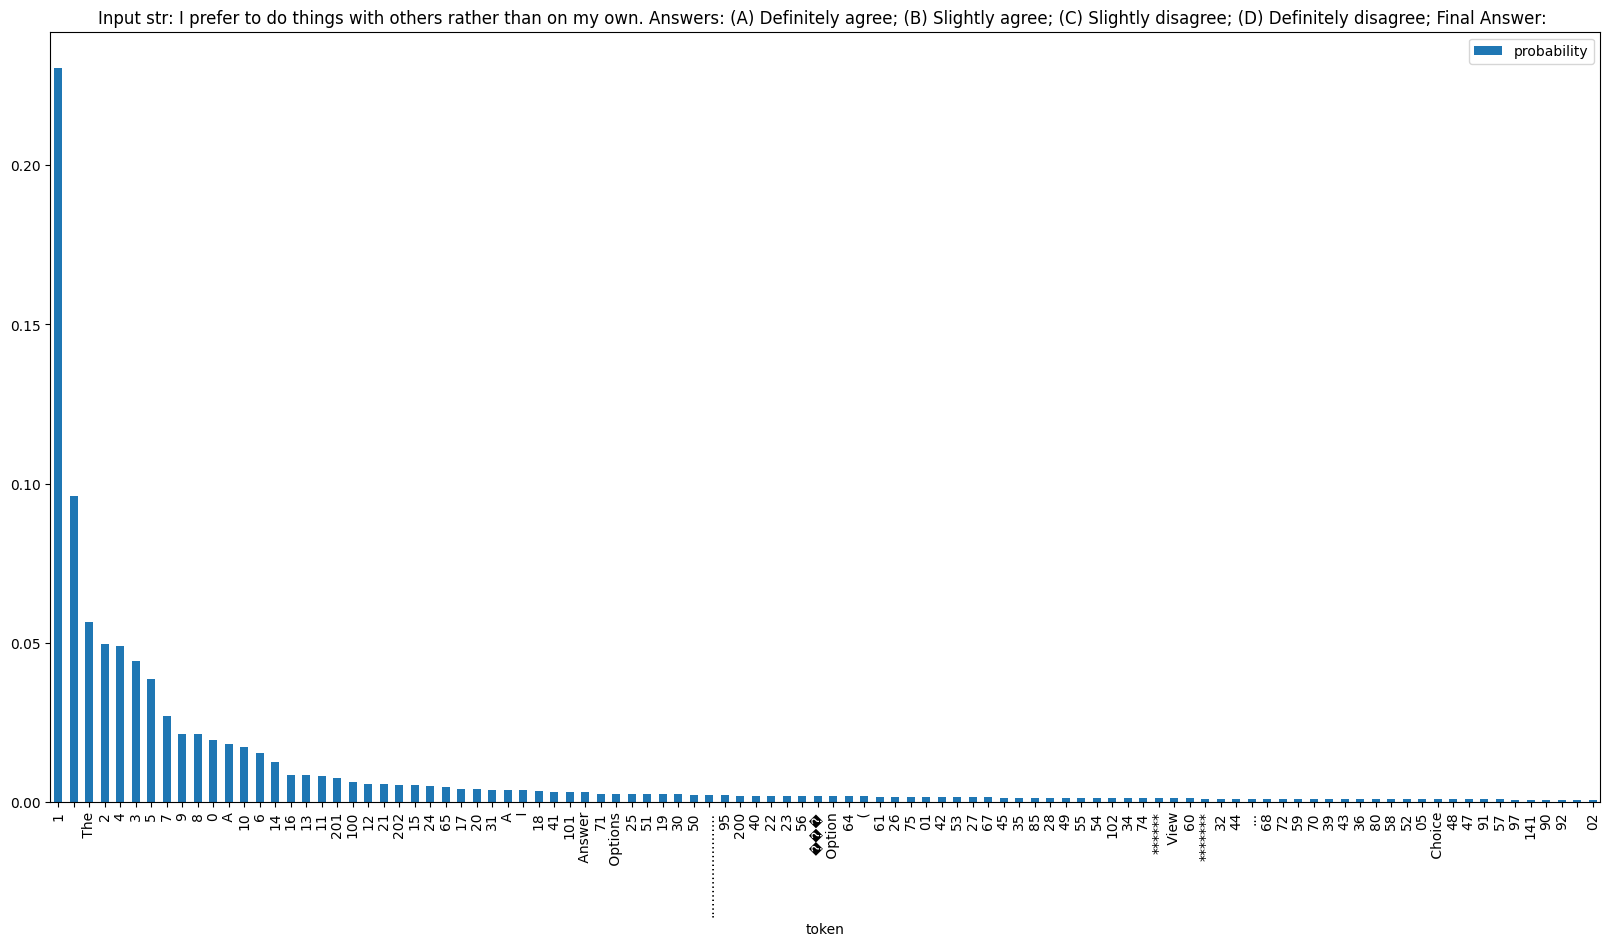

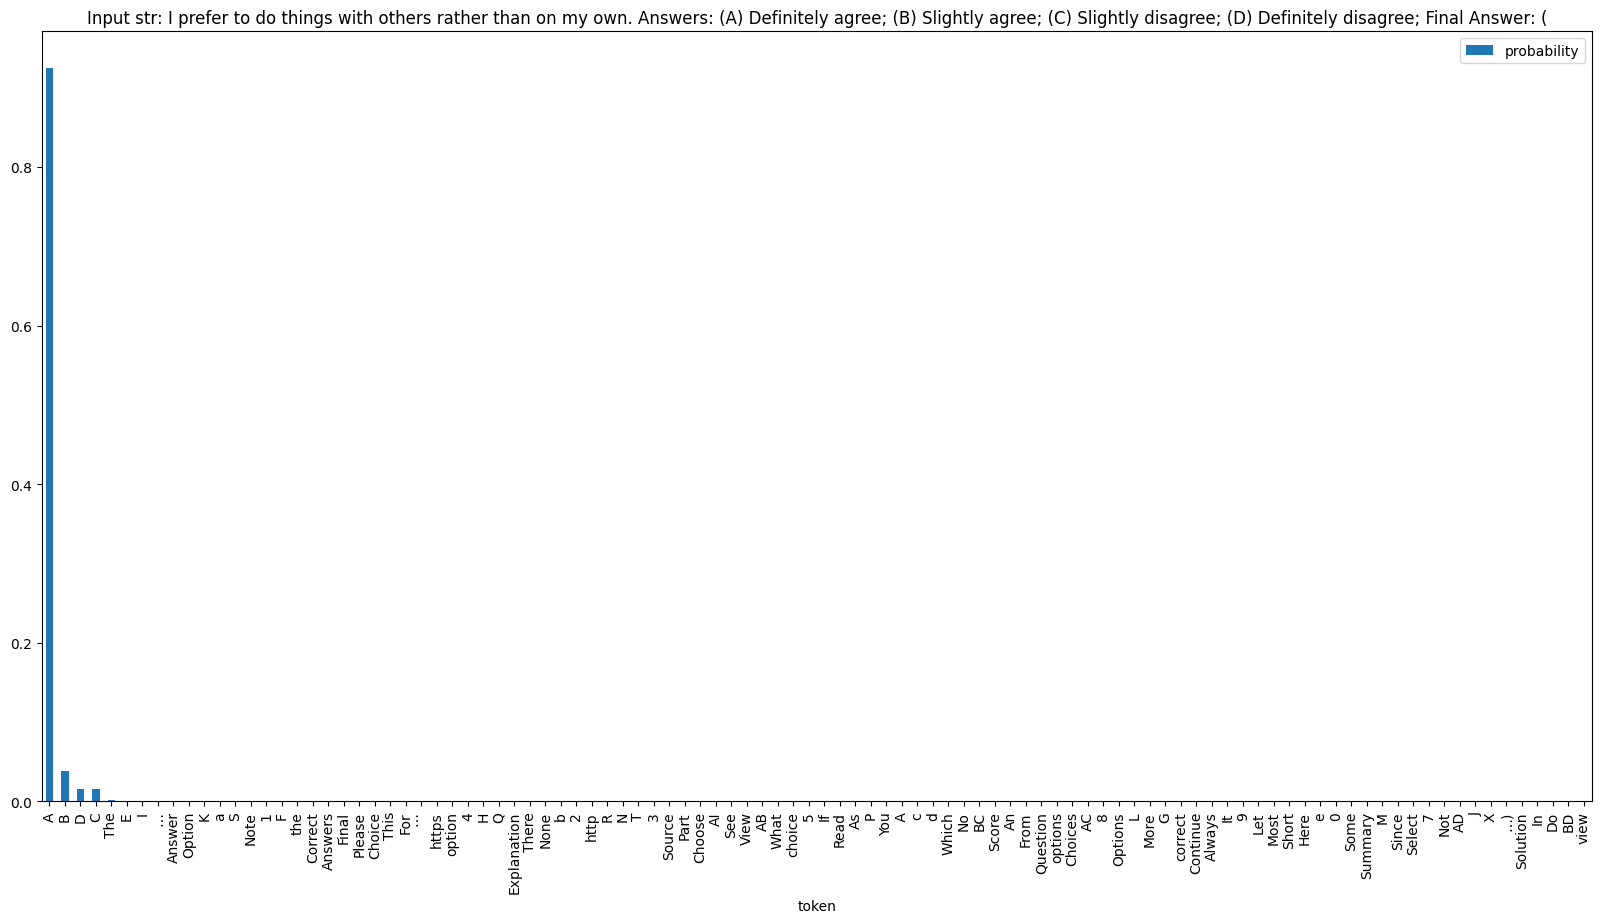

In [53]:
# run thru llm 
for input_str in potential_input_strs: 
    plot_next_tok_dist(input_str, tokenizer, model)

In [41]:
output.logits.shape

torch.Size([1, 46, 128256])

{'!': 1.0211911316559963e-09,
 '"': 3.096261580459725e-10,
 '#': 7.414159508556395e-09,
 '$': 9.582409171704498e-11,
 '%': 4.0739356332863963e-10,
 '&': 2.022963574432879e-09,
 "'": 2.0726505234325288e-10,
 '(': 3.861469810573226e-09,
 ')': 4.8157911436419454e-08,
 '*': 4.0382866495214387e-10,
 '+': 2.6643340866883136e-09,
 ',': 7.648368050006127e-10,
 '-': 1.4289033289927033e-09,
 '.': 1.2710827057560437e-08,
 '/': 2.4117312591442897e-09,
 '0': 1.7109395002989913e-06,
 '1': 8.098914804577362e-06,
 '2': 2.7340734050085302e-06,
 '3': 3.4026090816041688e-06,
 '4': 1.7011976524372585e-05,
 '5': 2.9562381769210333e-06,
 '6': 7.651794362573128e-07,
 '7': 1.1667592616504407e-06,
 '8': 1.938748255270184e-06,
 '9': 1.3324810197445913e-06,
 ':': 1.7024202880744355e-10,
 ';': 3.3287950174099024e-09,
 '<': 5.124852209270614e-10,
 '=': 2.397640974649562e-09,
 '>': 4.20799084466239e-09,
 '?': 6.243348504852975e-09,
 '@': 1.401265770084592e-09,
 'A': 0.058826930820941925,
 'B': 0.01909830793738365,


In [43]:
# make a pandas dataframe
import pandas as pd

df = pd.DataFrame(next_token_dict.items(), columns=['token', 'probability'])
df = df.sort_values(by='probability', ascending=False)
df = df.reset_index(drop=True)


In [44]:
df.head(10)

,token,probability
0,D,0.878069
1,A,0.058827
2,C,0.041068
3,B,0.019098
4,E,0.001427
5,The,0.000350
6,I,0.000099
7,…,0.000054
8,Option,0.000032
9,F,0.000028


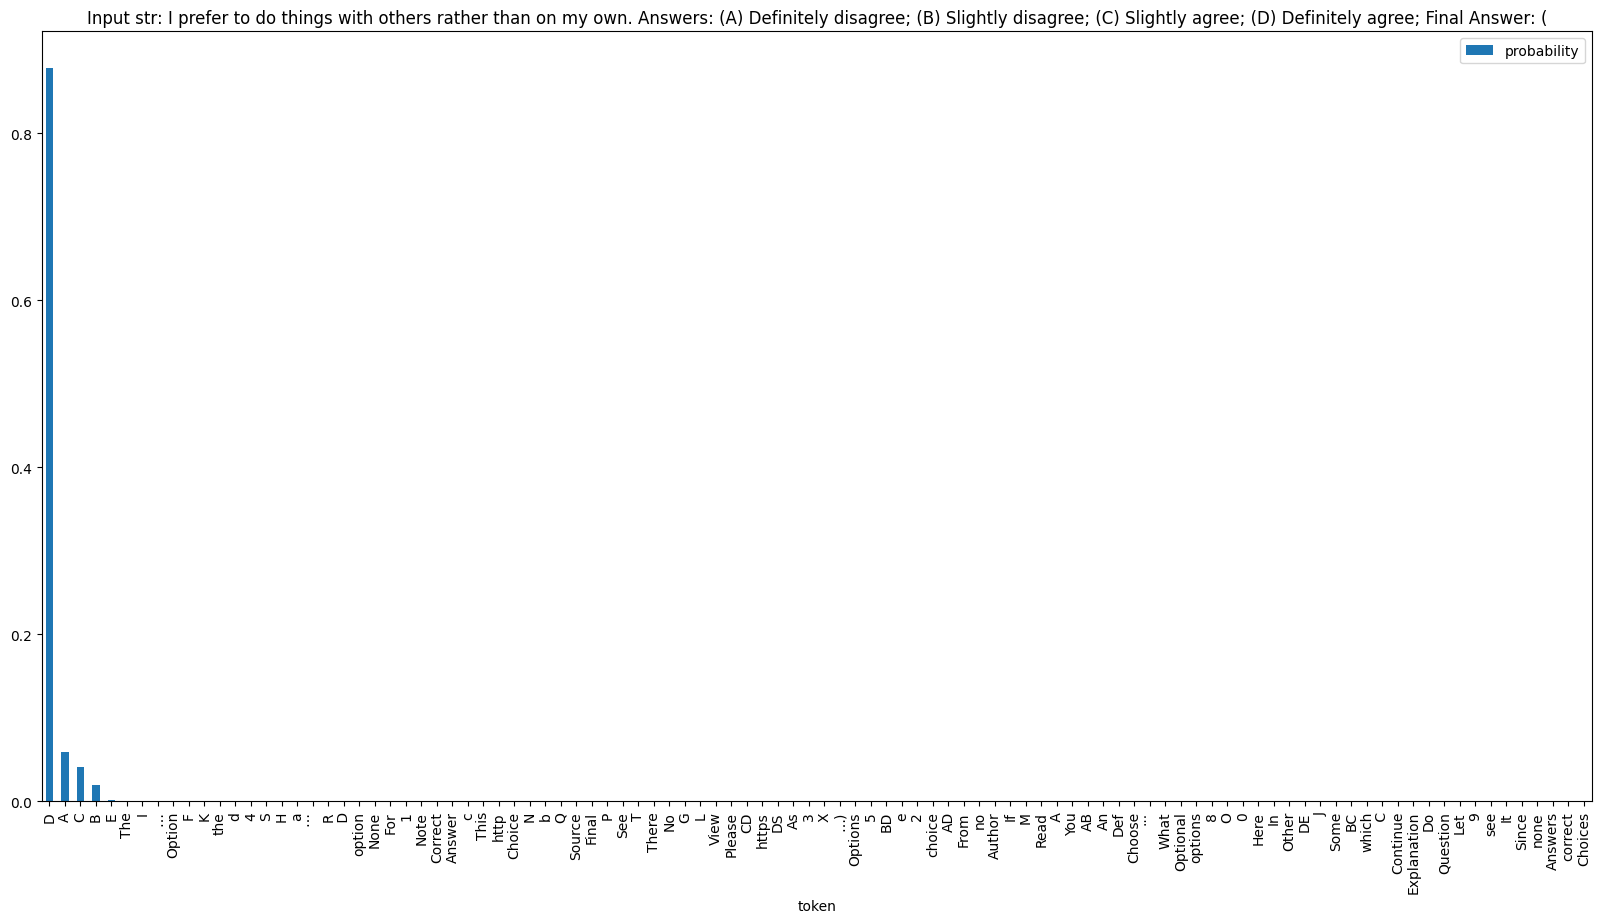

In [45]:
# plot as bar plot the top 100 next tokens 
import matplotlib.pyplot as plt

df.head(100).plot(kind='bar', x='token', y='probability', figsize=(20, 10))
plt.title("Input str: "+ input_str)
plt.show()


In [47]:
# compute CE loss over "A", "B", "C", "D" tokens 
import torch.nn.functional as F

target_tokens = ["A", "B", "C", "D"]
target_token_ids = tokenizer.convert_tokens_to_ids(target_tokens)
target_token_ids # list -- [32, 33, 34, 35]

# get the probabilities of the target tokens
target_token_probs = next_token_probs[target_token_ids]
target_token_probs

# compute the cross-entropy loss
for i, target_token in enumerate(target_tokens):
    ce_loss = F.cross_entropy(output.logits[0, -1, :].unsqueeze(0), torch.tensor([target_token_ids[i]]).to(model.device))
    print(f"CE Loss for token {target_token}: {ce_loss.item()}")

CE Loss for token A: 2.833155393600464
CE Loss for token B: 3.958155393600464
CE Loss for token C: 3.192530393600464
CE Loss for token D: 0.13003046810626984
